In [2]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

# Download census-income dataset

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [4]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

100% [.................................................] 3974305 / 3974305

# Load data and split

In [5]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [7]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [8]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cuda


# Training

In [9]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [23]:
max_epochs = 10000 if not os.getenv("CI", False) else 2

In [25]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=max_epochs,
    patience=70,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

epoch 0  | loss: 0.09506 | train_mse: 0.09194 | valid_mse: 0.09838 |  0:00:01s
epoch 1  | loss: 0.09353 | train_mse: 0.09055 | valid_mse: 0.09798 |  0:00:03s
epoch 2  | loss: 0.09278 | train_mse: 0.09435 | valid_mse: 0.10202 |  0:00:05s
epoch 3  | loss: 0.09222 | train_mse: 0.08962 | valid_mse: 0.09863 |  0:00:07s
epoch 4  | loss: 0.09238 | train_mse: 0.09121 | valid_mse: 0.09846 |  0:00:09s
epoch 5  | loss: 0.09297 | train_mse: 0.0931  | valid_mse: 0.10041 |  0:00:11s
epoch 6  | loss: 0.09225 | train_mse: 0.09039 | valid_mse: 0.09837 |  0:00:13s
epoch 7  | loss: 0.09263 | train_mse: 0.09041 | valid_mse: 0.09907 |  0:00:15s
epoch 8  | loss: 0.09372 | train_mse: 0.08955 | valid_mse: 0.09775 |  0:00:17s
epoch 9  | loss: 0.09182 | train_mse: 0.09102 | valid_mse: 0.09824 |  0:00:19s
epoch 10 | loss: 0.09252 | train_mse: 0.09094 | valid_mse: 0.10035 |  0:00:21s
epoch 11 | loss: 0.09146 | train_mse: 0.08994 | valid_mse: 0.09924 |  0:00:22s
epoch 12 | loss: 0.09209 | train_mse: 0.08905 | vali

In [26]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

BEST VALID SCORE FOR census-income : 0.0970204480057824
FINAL TEST SCORE FOR census-income : 0.10327615563191898


# Save model and load

In [27]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [28]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [29]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR census-income : 0.10327615563191898


In [30]:
assert(test_score == loaded_test_mse)

# Global explainability : feat importance summing to 1

In [31]:
clf.feature_importances_

array([0.17174022, 0.        , 0.        , 0.10159504, 0.01113549,
       0.06354857, 0.13259092, 0.01688147, 0.01866035, 0.        ,
       0.21675181, 0.26069232, 0.00316047, 0.00324334])

# Local explainability and masks

In [32]:
explain_matrix, masks = clf.explain(X_test)

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

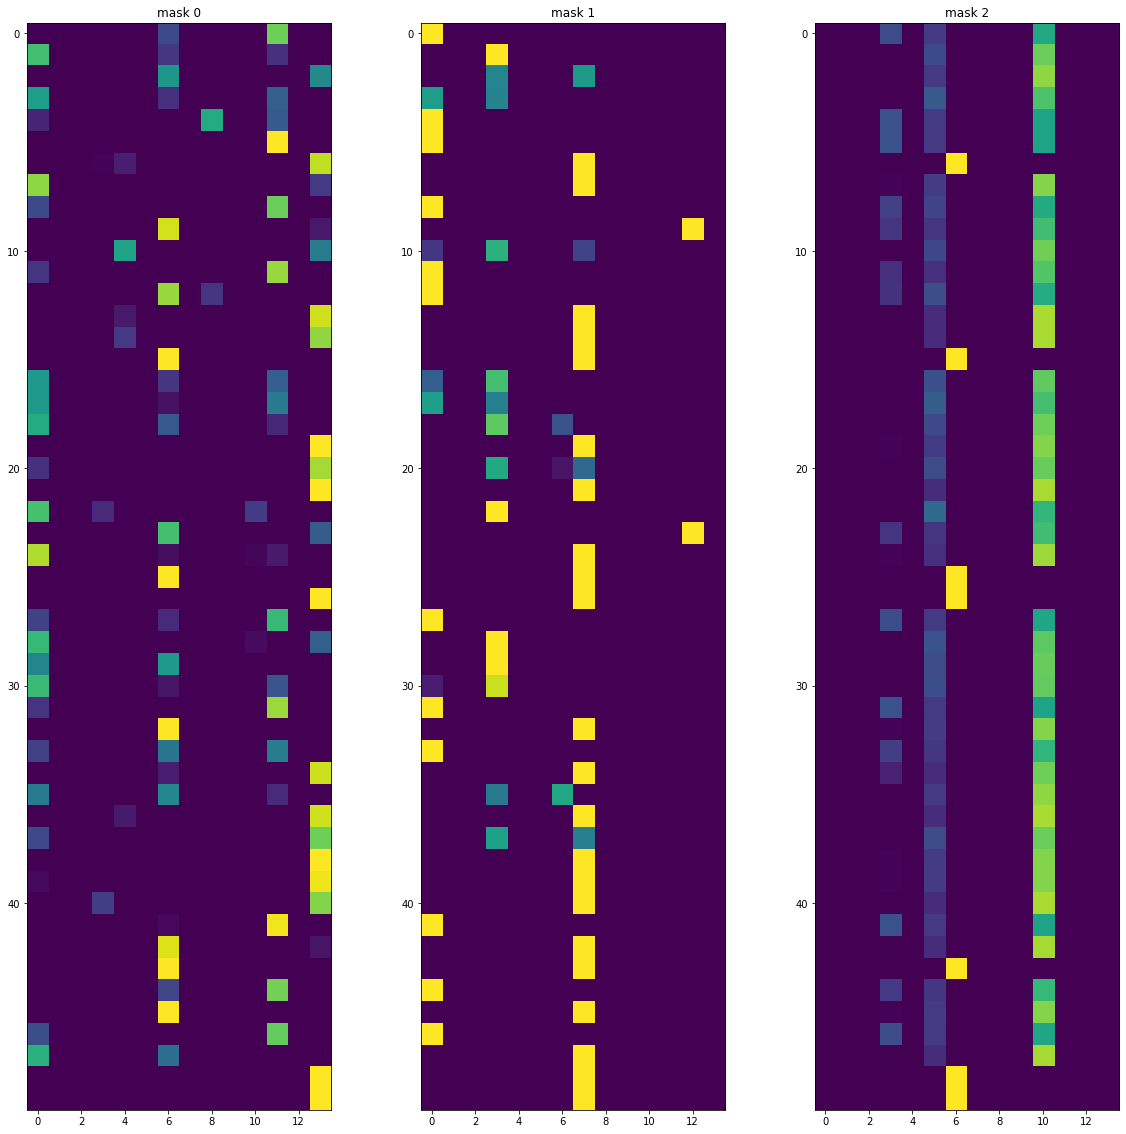

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [35]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=10000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.46992
[10]	validation_0-rmse:0.33056
[20]	validation_0-rmse:0.30274
[30]	validation_0-rmse:0.29676
[40]	validation_0-rmse:0.29514
[50]	validation_0-rmse:0.29520
[60]	validation_0-rmse:0.29497
[70]	validation_0-rmse:0.29518
[80]	validation_0-rmse:0.29521
[90]	validation_0-rmse:0.29574
[100]	validation_0-rmse:0.29599
[101]	validation_0-rmse:0.29598


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=-1, nthread=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=0, silent=None, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [22]:
preds = np.array(clf_xgb.predict(X_valid))
valid_mse = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_mse)

preds = np.array(clf_xgb.predict(X_test))
test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_mse)

0.08693414488964239
0.09148941118733249
